# Import

In [1]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
from transformers import DataCollatorWithPadding
import optuna
from huggingface_hub import notebook_login

# Datasets

In [3]:
# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

In [4]:
dataset_tweet= load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
dataset_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [5]:
dataset_tweet_cc = concatenate_datasets([dataset_tweet['train'], dataset_tweet['validation'],dataset_tweet['test']])
dataset_tweet_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 3033
})

In [6]:
dataset_mteb = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
dataset_mteb

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [8]:
dataset_mteb_cc = concatenate_datasets([dataset_mteb['train'], dataset_mteb['test']])
dataset_mteb_cc

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 31015
})

In [9]:
dataset_mteb_cc=dataset_mteb_cc.remove_columns('label_text')
dataset_mteb_cc=dataset_mteb_cc.remove_columns('id')

dataset_mteb_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 31015
})

In [10]:
dataset_tweet_cc.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [11]:
dataset_mteb_cc.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [12]:
features = dataset_mteb_cc.features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [dataset_mteb_cc for dataset_mteb_cc in batch["label"]]
    return batch
label_dataset = dataset_mteb_cc.map(adjust_labels, batched=True, features=features)

In [13]:
label_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [14]:
dataset_cc = concatenate_datasets([label_dataset, dataset_tweet_cc])
dataset_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 34048
})

## test dataset

In [15]:
notebook_login()

In [16]:
raw_dataset=load_dataset("HFFErica/sentimentanalysis")
print(raw_dataset)

DatasetDict({
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1700
    })
})


In [17]:
features = raw_dataset["test"].features.copy()
features["labels_three_2p"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["labels_three_2p"] = [test for test in batch["labels_three_2p"]]
    return batch
label_dataset = raw_dataset.map(adjust_labels, batched=True, features=features)

In [18]:
label_dataset["test"].features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [19]:
label_dataset_split = label_dataset['test'].train_test_split(test_size=0.4112, stratify_by_column="labels_three_2p")
label_dataset_split

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 700
    })
})

### test dataset groups

In [20]:
test_dataset=label_dataset_split['train']
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})

In [21]:
pretrain_test_dataset=label_dataset_split['test']
pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})

In [22]:
test_dataset.features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

### Pretrain merge

In [23]:
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_five')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_three')

pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels_three_2p'],
    num_rows: 700
})

In [24]:
pretrain_test_dataset=pretrain_test_dataset.rename_column("sequence", "text")
pretrain_test_dataset=pretrain_test_dataset.rename_column("labels_three_2p", "label")

pretrain_test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 700
})

In [25]:
dataset_ccc = concatenate_datasets([dataset_cc,pretrain_test_dataset])
dataset_ccc

Dataset({
    features: ['text', 'label'],
    num_rows: 34748
})

## split 

In [26]:
ds = dataset_ccc.train_test_split(test_size=0.2, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27798
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6950
    })
})

In [27]:
train_dataset = ds['train']
validation_dataset = ds['test']
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27798
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6950
})


## label balance

<Axes: ylabel='count'>

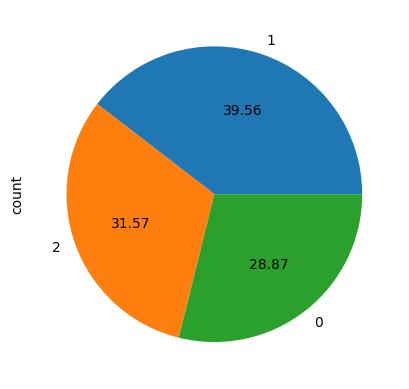

In [28]:
df_train = train_dataset.to_pandas()
df_train.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

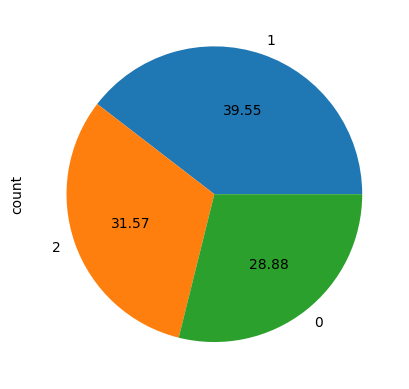

In [29]:
df_validation = validation_dataset.to_pandas()
df_validation.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

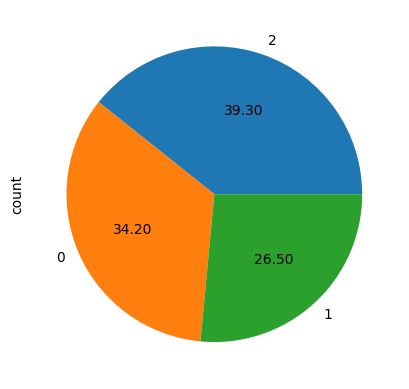

In [30]:
df_test = test_dataset.to_pandas()
df_test.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

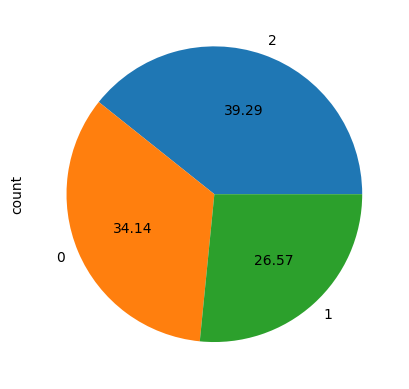

In [31]:
df_pretest = pretrain_test_dataset.to_pandas()
df_pretest.label.value_counts().plot(kind = 'pie', autopct="%.2f")

## Map

In [32]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)
print(pretrain_test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27798
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6950
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 700
})


In [33]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['labels_three_2p']}, batched=True)

Map:   0%|          | 0/27798 [00:00<?, ? examples/s]

Map:   0%|          | 0/6950 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model 

In [34]:
model_id="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"



# label2id = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                           num_labels=train_dataset.features["label"].num_classes,
#                                                            id2label=label2id,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

RobertaConfig {
  "_name_or_path": "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [35]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sequence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/27798 [00:00<?, ? examples/s]

Map:   0%|          | 0/6950 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [36]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [37]:
# train_dataset.set_format(type='torch', columns=['input_ids','token_type_ids', 'attention_mask', 'labels'])
# validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [38]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameter search

In [39]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [40]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset, 
    eval_dataset=validation_dataset, 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

In [41]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [ ]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2023-12-07 13:18:19,769] A new study created in memory with name: no-name-77cd02ba-6576-4588-9fd6-90f2c40b816a
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7397, 'learning_rate': 1.7348223597028135e-06, 'epoch': 1.01}
{'eval_loss': 0.5978348255157471, 'eval_accuracy': 0.7438848920863309, 'eval_f1': 0.7470744758594837, 'eval_precision': 0.7437494930168912, 'eval_recall': 0.7536703973517244, 'eval_runtime': 21.5707, 'eval_samples_per_second': 322.196, 'eval_steps_per_second': 40.286, 'epoch': 1.01}


[I 2023-12-07 13:26:56,503] Trial 0 finished with value: 2.9883792583144304 and parameters: {'learning_rate': 3.4907154363250946e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 56}. Best is trial 0 with value: 2.9883792583144304.


{'train_runtime': 496.2452, 'train_samples_per_second': 112.033, 'train_steps_per_second': 2.003, 'train_loss': 0.672291439064072, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.797, 'learning_rate': 1.835892564513704e-06, 'epoch': 0.86}
{'eval_loss': 0.6104449033737183, 'eval_accuracy': 0.7384172661870504, 'eval_f1': 0.7419186579925511, 'eval_precision': 0.7388707997267714, 'eval_recall': 0.7475077696544377, 'eval_runtime': 22.0191, 'eval_samples_per_second': 315.635, 'eval_steps_per_second': 39.466, 'epoch': 0.86}
{'loss': 0.6143, 'learning_rate': 1.4534149469066824e-06, 'epoch': 1.72}
{'eval_loss': 0.584314227104187, 'eval_accuracy': 0.7506474820143885, 'eval_f1': 0.754295462891796, 'eval_precision': 0.7522460246101841, 'eval_recall': 0.756991132728241, 'eval_runtime': 21.5972, 'eval_samples_per_second': 321.801, 'eval_steps_per_second': 40.237, 'epoch': 1.72}
{'loss': 0.5802, 'learning_rate': 1.0709373292996608e-06, 'epoch': 2.59}
{'eval_loss': 0.5765090584754944, 'eval_accuracy': 0.7561151079136691, 'eval_f1': 0.7596223517190657, 'eval_precision': 0.757373510712943, 'eval_recall': 0.7625851102516767, 'eval_runtime': 21.6027, 'eval_samples_per_s

[I 2023-12-07 13:48:42,678] Trial 1 finished with value: 3.047123002734536 and parameters: {'learning_rate': 2.2183701821207258e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 48}. Best is trial 1 with value: 3.047123002734536.


{'train_runtime': 1304.4622, 'train_samples_per_second': 106.55, 'train_steps_per_second': 2.223, 'train_loss': 0.6177461663607894, 'epoch': 5.0}


eval/accuracy,▁▅▇██
eval/f1,▁▅▇██
eval/loss,█▄▃▂▁
eval/precision,▁▅▇██
eval/recall,▁▄▆█▇
eval/runtime,█▁▁▁▁
eval/samples_per_second,▁████
eval/steps_per_second,▁████
train/epoch,▁▁▂▂▄▄▅▅▇▇█
train/global_step,▁▁▂▂▄▄▅▅▇▇█
train/learning_rate,█▆▄▃▁


{'loss': 0.6672, 'learning_rate': 4.22907688705082e-06, 'epoch': 1.01}
{'eval_loss': 0.5646209120750427, 'eval_accuracy': 0.7611510791366907, 'eval_f1': 0.7650626452872968, 'eval_precision': 0.7633449038574818, 'eval_recall': 0.768088990139394, 'eval_runtime': 21.5872, 'eval_samples_per_second': 321.95, 'eval_steps_per_second': 40.255, 'epoch': 1.01}


[I 2023-12-07 13:56:48,241] Trial 2 finished with value: 3.057647618420863 and parameters: {'learning_rate': 8.509519080422096e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 56}. Best is trial 2 with value: 3.057647618420863.


{'train_runtime': 483.8575, 'train_samples_per_second': 114.902, 'train_steps_per_second': 2.054, 'train_loss': 0.6107315892424862, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 1.1122, 'learning_rate': 3.901532960642058e-05, 'epoch': 0.86}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0896615982055664, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.682, 'eval_samples_per_second': 320.542, 'eval_steps_per_second': 40.079, 'epoch': 0.86}


[I 2023-12-07 14:01:20,283] Trial 3 finished with value: 1.0496736121773784 and parameters: {'learning_rate': 0.0002828611396465492, 'num_train_epochs': 1, 'per_device_train_batch_size': 48}. Best is trial 2 with value: 3.057647618420863.


{'train_runtime': 270.4108, 'train_samples_per_second': 102.799, 'train_steps_per_second': 2.145, 'train_loss': 1.1083113703234442, 'epoch': 1.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁█
train/global_step,▁▁█
train/learning_rate,▁


{'loss': 0.938, 'learning_rate': 8.54085468885261e-07, 'epoch': 0.86}
{'eval_loss': 0.6539843678474426, 'eval_accuracy': 0.7192805755395684, 'eval_f1': 0.7224098210377544, 'eval_precision': 0.7190695142356179, 'eval_recall': 0.7289740747160381, 'eval_runtime': 21.6247, 'eval_samples_per_second': 321.392, 'eval_steps_per_second': 40.186, 'epoch': 0.86}
{'loss': 0.6607, 'learning_rate': 6.761509962008317e-07, 'epoch': 1.72}
{'eval_loss': 0.6181939244270325, 'eval_accuracy': 0.7341007194244604, 'eval_f1': 0.7375867760831376, 'eval_precision': 0.7346353426283082, 'eval_recall': 0.7421028807662046, 'eval_runtime': 21.6151, 'eval_samples_per_second': 321.534, 'eval_steps_per_second': 40.203, 'epoch': 1.72}
{'loss': 0.6224, 'learning_rate': 4.982165235164023e-07, 'epoch': 2.59}
{'eval_loss': 0.6044266223907471, 'eval_accuracy': 0.7412949640287769, 'eval_f1': 0.7447888958901663, 'eval_precision': 0.7417307148490617, 'eval_recall': 0.7499564960611879, 'eval_runtime': 21.5933, 'eval_samples_per_

[I 2023-12-07 14:23:07,684] Trial 4 finished with value: 3.0001254300823987 and parameters: {'learning_rate': 1.0320199415696905e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 48}. Best is trial 2 with value: 3.057647618420863.


{'train_runtime': 1305.8831, 'train_samples_per_second': 106.434, 'train_steps_per_second': 2.221, 'train_loss': 0.6794123156317349, 'epoch': 5.0}


eval/accuracy,▁▅▇▇█
eval/f1,▁▅▇▇█
eval/loss,█▄▂▂▁
eval/precision,▁▅▇▇█
eval/recall,▁▅▇██
eval/runtime,█▆▁▂█
eval/samples_per_second,▁▃█▇▁
eval/steps_per_second,▁▃█▇▁
train/epoch,▁▁▂▂▄▄▅▅▇▇█
train/global_step,▁▁▂▂▄▄▅▅▇▇█
train/learning_rate,█▆▅▃▁


{'loss': 1.111, 'learning_rate': 0.00027926525142027604, 'epoch': 0.65}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-07 14:26:07,014] Trial 5 pruned. 


{'eval_loss': 0.9951984286308289, 'eval_accuracy': 0.5214388489208633, 'eval_f1': 0.4034838356449302, 'eval_precision': 0.3940760495362805, 'eval_recall': 0.47354121976235325, 'eval_runtime': 21.5819, 'eval_samples_per_second': 322.029, 'eval_steps_per_second': 40.265, 'epoch': 0.65}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.9868, 'learning_rate': 0.00019650972073439403, 'epoch': 0.29}


[I 2023-12-07 14:27:50,356] Trial 6 pruned. 


{'eval_loss': 0.892381489276886, 'eval_accuracy': 0.6100719424460431, 'eval_f1': 0.614127924267223, 'eval_precision': 0.6423024809363939, 'eval_recall': 0.6258651345450824, 'eval_runtime': 21.503, 'eval_samples_per_second': 323.21, 'eval_steps_per_second': 40.413, 'epoch': 0.29}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.6053, 'learning_rate': 2.3399331493915933e-05, 'epoch': 1.15}
{'eval_loss': 0.5758718252182007, 'eval_accuracy': 0.7671942446043165, 'eval_f1': 0.769924957007837, 'eval_precision': 0.7668687625757714, 'eval_recall': 0.7765841112851325, 'eval_runtime': 21.5266, 'eval_samples_per_second': 322.856, 'eval_steps_per_second': 40.369, 'epoch': 1.15}
{'loss': 0.4758, 'learning_rate': 1.6414456421105208e-05, 'epoch': 2.3}
{'eval_loss': 0.603039562702179, 'eval_accuracy': 0.7702158273381295, 'eval_f1': 0.7730011847032094, 'eval_precision': 0.7723042485263968, 'eval_recall': 0.7757305743340207, 'eval_runtime': 21.5304, 'eval_samples_per_second': 322.8, 'eval_steps_per_second': 40.362, 'epoch': 2.3}
{'loss': 0.3846, 'learning_rate': 9.429581348294481e-06, 'epoch': 3.45}
{'eval_loss': 0.6284129619598389, 'eval_accuracy': 0.7720863309352518, 'eval_f1': 0.7750471779838257, 'eval_precision': 0.772824387042423, 'eval_recall': 0.7814806719204158, 'eval_runtime': 21.5486, 'eval_samples_per_sec

[I 2023-12-07 14:48:49,632] Trial 7 finished with value: 3.092188857483947 and parameters: {'learning_rate': 3.038420656672666e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}. Best is trial 7 with value: 3.092188857483947.


{'train_runtime': 1258.1524, 'train_samples_per_second': 110.472, 'train_steps_per_second': 1.729, 'train_loss': 0.43486595943056305, 'epoch': 5.0}


eval/accuracy,▁▅█▆
eval/f1,▁▅█▆
eval/loss,▁▃▅█
eval/precision,▁▇█▇
eval/recall,▂▁█▂
eval/runtime,▁▂█▁
eval/samples_per_second,█▇▁█
eval/steps_per_second,█▇▁█
train/epoch,▁▁▃▃▅▅▇▇█
train/global_step,▁▁▃▃▅▅▇▇█
train/learning_rate,█▆▃▁


{'loss': 0.6474, 'learning_rate': 2.5050737852728643e-05, 'epoch': 0.65}
{'eval_loss': 0.5725969672203064, 'eval_accuracy': 0.7664748201438849, 'eval_f1': 0.7700342642315056, 'eval_precision': 0.7695790991374277, 'eval_recall': 0.7767021002365339, 'eval_runtime': 21.5394, 'eval_samples_per_second': 322.665, 'eval_steps_per_second': 40.345, 'epoch': 0.65}
{'loss': 0.518, 'learning_rate': 1.307619777016237e-05, 'epoch': 1.29}
{'eval_loss': 0.5565701127052307, 'eval_accuracy': 0.7736690647482014, 'eval_f1': 0.7767703208699296, 'eval_precision': 0.7745963254696834, 'eval_recall': 0.7796811997032647, 'eval_runtime': 21.6065, 'eval_samples_per_second': 321.662, 'eval_steps_per_second': 40.219, 'epoch': 1.29}
{'loss': 0.4598, 'learning_rate': 1.1016576875960972e-06, 'epoch': 1.94}
{'eval_loss': 0.5673254728317261, 'eval_accuracy': 0.7738129496402878, 'eval_f1': 0.7772898787520001, 'eval_precision': 0.7749652599290098, 'eval_recall': 0.7804442064090161, 'eval_runtime': 21.5737, 'eval_samples_p

[I 2023-12-07 14:58:33,690] Trial 8 finished with value: 3.106512294730314 and parameters: {'learning_rate': 3.7025277935294915e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 36}. Best is trial 8 with value: 3.106512294730314.


{'train_runtime': 582.461, 'train_samples_per_second': 95.45, 'train_steps_per_second': 2.654, 'train_loss': 0.5400952145476545, 'epoch': 2.0}


eval/accuracy,▁██
eval/f1,▁▇█
eval/loss,█▁▆
eval/precision,▁██
eval/recall,▁▇█
eval/runtime,▁█▅
eval/samples_per_second,█▁▄
eval/steps_per_second,█▁▄
train/epoch,▁▁▄▄███
train/global_step,▁▁▄▄███
train/learning_rate,█▄▁


# Trainer

In [39]:
training_args = TrainingArguments(
    output_dir='./yresults',          # output directory
    learning_rate= 2.9391299899496174e-05,
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    seed=42,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.740900,0.576589,0.756978,0.760626,0.757898,0.765420
200,0.599200,0.602208,0.749065,0.750576,0.750610,0.763821
300,0.590100,0.548159,0.770647,0.774543,0.773255,0.776635
400,0.576200,0.549536,0.761871,0.764184,0.792009,0.753132
500,0.525600,0.540592,0.778417,0.782528,0.782447,0.783605
600,0.494500,0.533985,0.781151,0.785322,0.787637,0.783511
700,0.499800,0.536928,0.780288,0.784139,0.784036,0.786998
800,0.507500,0.531689,0.781583,0.785420,0.785887,0.787134
900,0.453900,0.564331,0.780432,0.784773,0.786097,0.783943
1000,0.435600,0.544172,0.777698,0.781120,0.788685,0.776645


In [40]:
train_out

TrainOutput(global_step=1740, training_loss=0.4771093028715287, metrics={'train_runtime': 1271.6816, 'train_samples_per_second': 87.437, 'train_steps_per_second': 1.368, 'total_flos': 7364788833890304.0, 'train_loss': 0.4771093028715287, 'epoch': 4.0})

# Confusion matrix

In [51]:
def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [52]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

In [53]:
preds_output.metrics

{'test_loss': 0.8004580140113831,
 'test_accuracy': 0.679,
 'test_f1': 0.6687126492602551,
 'test_precision': 0.6990943445805544,
 'test_recall': 0.665058697121282,
 'test_runtime': 2.9173,
 'test_samples_per_second': 342.779,
 'test_steps_per_second': 5.484}

In [54]:
y_preds = np.argmax(preds_output.predictions, axis=1)

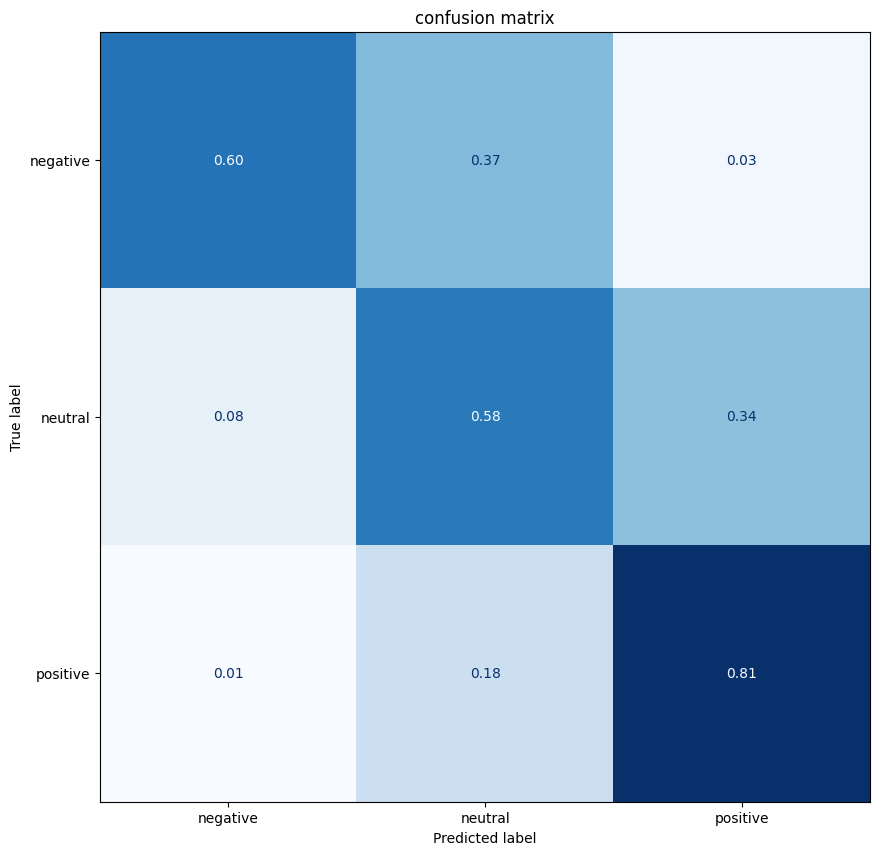

In [55]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Validation

In [56]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

In [57]:
preds_output.metrics

{'test_loss': 0.5405923128128052,
 'test_accuracy': 0.7784172661870503,
 'test_f1': 0.7825281834036756,
 'test_precision': 0.782447470096817,
 'test_recall': 0.7836047231661581,
 'test_runtime': 18.5732,
 'test_samples_per_second': 374.194,
 'test_steps_per_second': 5.869}

In [58]:
y_preds = np.argmax(preds_output.predictions, axis=1)

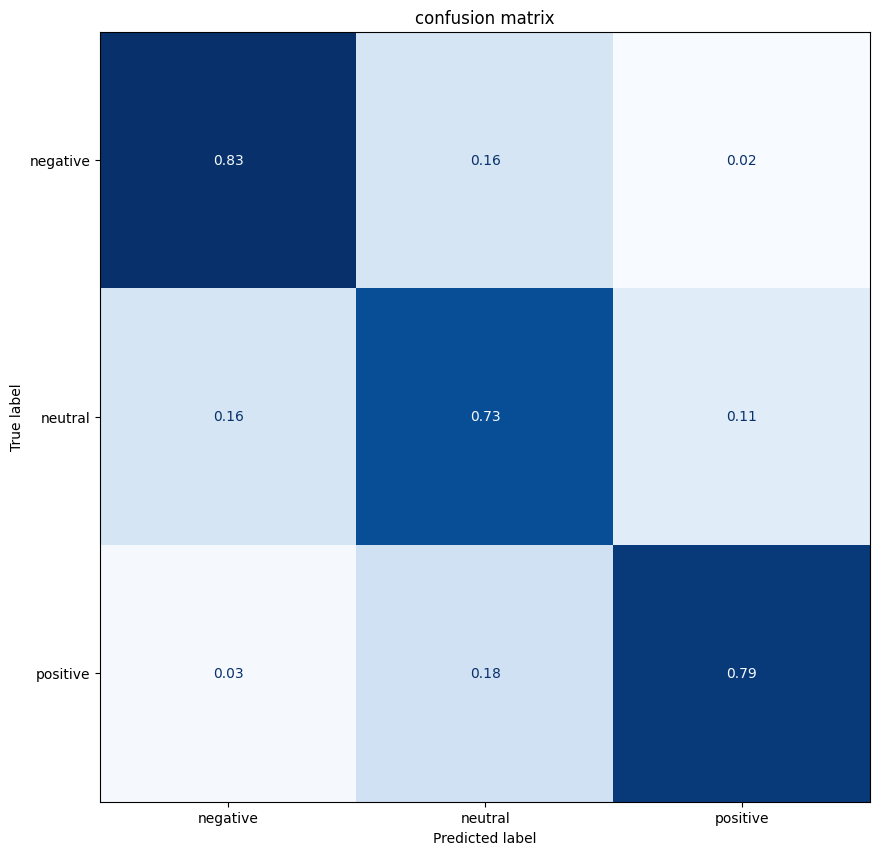

In [59]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [60]:
%%notify
import time
time.sleep(1)

<IPython.core.display.Javascript object>